## Machine Learning Project: Afshan Akmal
Dataset: Individual Age of Death and Related Factors

**Step 1: Upload Data Set **

In [9]:
#Download all the necessary libraries
!pip install xgboost
import kagglehub
import os
import json
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor

import re

In [10]:
#Load up the current dataset
json_path = "data.json"

#Convert the list of records to a DataFrame
df = pd.read_json(json_path)

#Preview the first few rows
df.head()


,age,weight,sex,height,sys_bp,smoker,nic_other,num_meds,occup_danger,ls_danger,...,addiction,major_surgery_num,diabetes,hds,cholesterol,asthma,immune_defic,family_cancer,family_heart_disease,family_cholesterol
0,100,219,m,74,136,n,n,0,1,1,...,n,0,n,y,203,n,n,y,n,y
1,66,242,m,73,111,n,n,0,1,1,...,y,0,n,n,228,n,n,n,n,n
2,31,197,f,65,112,n,n,7,1,2,...,y,3,n,y,183,n,n,n,n,n
3,42,244,f,69,127,n,n,1,2,3,...,n,2,n,y,228,n,n,n,n,n
4,93,183,f,63,91,y,n,2,3,3,...,y,2,n,n,169,n,n,n,n,n


**Data Processing and Data Cleaning**



In [11]:
#Preview dataframe shapes and observe column data types
print(df.shape)
df.dtypes

(10000, 24)


,0
age,int64
weight,int64
sex,object
height,int64
sys_bp,int64
smoker,object
nic_other,object
num_meds,int64
occup_danger,int64
ls_danger,int64


In [12]:
#checks if json df is nested
def check_if_nested(df):
    check_nest = []

    for _, row in df.iterrows():
        for value in row:
            if isinstance(value, (dict, list)):
                check_nest.append('nested')
            else:
                check_nest.append('not nested')

    return 'nested' in check_nest

# Example usage
# Assuming `df` is a Pandas DataFrame
print("Is DF nested: ")
print(check_if_nested(df))

#We can confirm that dataset is not nested

Is DF nested: 
False


In [32]:
#Data Cleaning - Locate Null Values
df.replace(["", "nan", "NaN", "None", "-", "N/A", " "], np.nan, inplace=True)
df = df.convert_dtypes()
df = df.astype({col: 'object' for col in df.select_dtypes(include='integer').columns})

# 2. Define a function to replace things that look blank
def force_blank_to_nan(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and re.fullmatch(r'\s*', x):  # empty or all spaces
        return np.nan
    if str(x).strip().lower() in ["nan", "none", "n/a", "-"]:
        return np.nan
    return x

# 3. Apply the cleaning to every cell
df = df.applymap(force_blank_to_nan)

# 4. Now count missing
total_missing = df.isnull().sum()
print(total_missing)

<ipython-input-32-24f7faf7d122>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(force_blank_to_nan)


age                     0
weight                  0
sex                     0
height                  0
sys_bp                  0
smoker                  0
nic_other               0
num_meds                0
occup_danger            0
ls_danger               0
cannabis                0
opioids                 0
other_drugs             0
drinks_aweek            0
addiction               0
major_surgery_num       0
diabetes                0
hds                     0
cholesterol             0
asthma                  0
immune_defic            0
family_cancer           0
family_heart_disease    0
family_cholesterol      0
bmi                     0
dtype: int64


In [33]:
#check the types of values for each column
for col in df.columns:
    print(f"--- {col} ---")
    print(df[col].unique())

--- age ---
[100  66  31  42  93  84  83  97  45  98  71  78  35  55  50  46  95  61
  51  64  86  39  79  75  52  67  65  59  63  58  56  89  28  26  69  30
  44 116  27  77  43  33  87  57 101  96  60  53  82  70  81  99  41  80
  32  85  90  76  37  91  68  49  48  25  73  88  47  36  38  72  94  34
  74  54  29  40 102 108 111  92 103 106 109  62 107 112 117 113 104 118
 105 115 120 119 110 114]
--- weight ---
[219 242 197 244 183 230 220 199 160 200 236 239 282 203 231 280 135 210
 184 180 201 175 228 235 188 215 181 223 218 222 276 206 192 266 256 258
 202 229 198 189 233 204 205 177 243 194 190 193 232 208 212 217 168 153
 287 165 196 249 178 240 155 307 238 163 303 179 253 290 209 252 225 187
 275 286 122 254 241 284 226 176 255 248 150 257 207 261 221 271 216 211
 259 237 326 191 213 227 224 147 164 250 141 214 270 247 195 124 262 268
 182 169 162 173 305 170 260 297 245 156 251 279 140 265 263 158 292 246
 171 142 172 234 309 167 327 126 151 144 149 269 272 311 277 186 267 27

In [16]:
#Get basic data statistics
df.describe()

,age,weight,height,sys_bp,num_meds,occup_danger,ls_danger,drinks_aweek,major_surgery_num,cholesterol
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000
mean,64.63570,214.725500,67.237100,126.482400,4.590500,1.996800,2.0056,9.983400,4.170900,199.736100
std,23.19368,35.624989,3.897127,14.279162,5.512372,0.819425,0.8166,5.556601,2.964013,35.633212
min,25.00000,97.000000,53.000000,67.000000,0.000000,1.000000,1.0000,0.000000,0.000000,83.000000
25%,46.00000,190.000000,64.000000,117.000000,0.000000,1.000000,1.0000,6.000000,2.000000,175.000000
50%,64.00000,214.000000,67.000000,126.000000,3.000000,2.000000,2.0000,9.000000,4.000000,199.000000
75%,82.00000,238.000000,70.000000,136.000000,7.000000,3.000000,3.0000,13.000000,6.000000,223.000000
max,120.00000,366.000000,82.000000,180.000000,53.000000,3.000000,3.0000,37.000000,16.000000,351.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'weight'}>],
       [<Axes: title={'center': 'drinks_aweek'}>,
        <Axes: title={'center': 'major_surgery_num'}>],
       [<Axes: title={'center': 'sys_bp'}>, <Axes: >]], dtype=object)

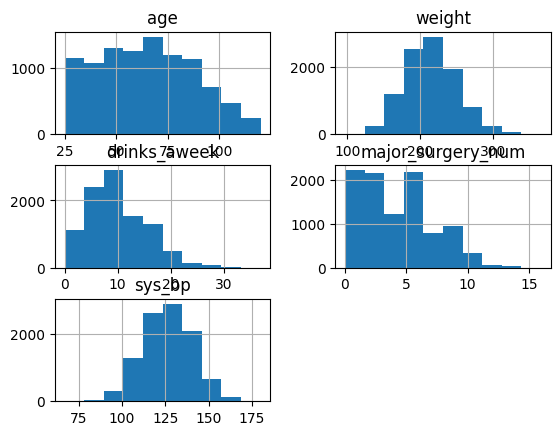

In [17]:
#Visualize numerical columns
df[['age','weight', 'drinks_aweek', 'major_surgery_num', 'sys_bp']].hist()

In [18]:
#Understanding binary data --> Lifestyle Habits

#Gender
gender_counts = df['sex'].value_counts(normalize=True) * 100
print(f"Female: {gender_counts.get('f', 0):.2f}%")
print(f"Male: {gender_counts.get('m', 0):.2f}%")

#smoker
smoker_counts = df['smoker'].value_counts(normalize=True) * 100
print(f"Smoker: {smoker_counts.get('y', 0):.2f}%")
print(f"Non-Smoker: {smoker_counts.get('n', 0):.2f}%")

#canabis
canabis_count = df['cannabis'].value_counts(normalize=True) * 100
print(f"Uses Canabis: {canabis_count.get('y', 0):.2f}%")
print(f"Does not use canabis: {canabis_count.get('n', 0):.2f}%")
#opioids
opioids = df['opioids'].value_counts(normalize=True) * 100
print(f"Uses ops: {opioids.get('y', 0):.2f}%")
print(f"Does not use ops: {opioids.get('n', 0):.2f}%")

#adddiction
addiction = df['addiction'].value_counts(normalize=True) * 100
print(f"Addiction: {addiction.get('y', 0):.2f}%")
print(f"No addiction: {addiction.get('n', 0):.2f}%")

Female: 50.34%
Male: 49.66%
Smoker: 20.06%
Non-Smoker: 79.94%
Uses Canabis: 2.71%
Does not use canabis: 97.29%
Uses ops: 4.19%
Does not use ops: 95.81%
Addiction: 32.52%
No addiction: 67.48%


In [19]:
ls_danger_dist = df['ls_danger'].value_counts()
occup_danger_dist = df['occup_danger'].value_counts()

print("LS Danger Distribution:")
print(ls_danger_dist)

print("\nOccupational Danger Distribution:")
print(occup_danger_dist)


LS Danger Distribution:
ls_danger
3    3362
2    3332
1    3306
Name: count, dtype: int64

Occupational Danger Distribution:
occup_danger
1    3373
3    3341
2    3286
Name: count, dtype: int64


In [20]:
#Understanding binary data --> Health Data/Issues

#Gender
asthma_counts = df['asthma'].value_counts(normalize=True) * 100
print(f"Yes Asthma: {asthma_counts.get('y', 0):.2f}%")
print(f"No Asthma: {asthma_counts.get('n', 0):.2f}%")

#smoker
immune_defic = df['immune_defic'].value_counts(normalize=True) * 100
print(f"Yes Immune Defic: {immune_defic.get('y', 0):.2f}%")
print(f"No Immune Defic: {immune_defic.get('n', 0):.2f}%")

#canabis
fam_cancer_count = df['family_cancer'].value_counts(normalize=True) * 100
print(f"Fam Cancer: {fam_cancer_count.get('y', 0):.2f}%")
print(f"No Family Cancer: {fam_cancer_count.get('n', 0):.2f}%")

#opioids
fam_heart_disease = df['family_heart_disease'].value_counts(normalize=True) * 100
print(f"Fam has heart disease: {fam_heart_disease.get('y', 0):.2f}%")
print(f"Fam doesn't have heart disease: {fam_heart_disease.get('n', 0):.2f}%")

#adddiction
fam_chol = df['family_cholesterol'].value_counts(normalize=True) * 100
print(f"Fam has cholesterol: {fam_chol.get('y', 0):.2f}%")
print(f"Fam doesn't have cholesterol: {fam_chol.get('n', 0):.2f}%")

Yes Asthma: 7.82%
No Asthma: 92.18%
Yes Immune Defic: 3.12%
No Immune Defic: 96.88%
Fam Cancer: 35.13%
No Family Cancer: 64.87%
Fam has heart disease: 12.69%
Fam doesn't have heart disease: 87.31%
Fam has cholesterol: 18.40%
Fam doesn't have cholesterol: 81.60%


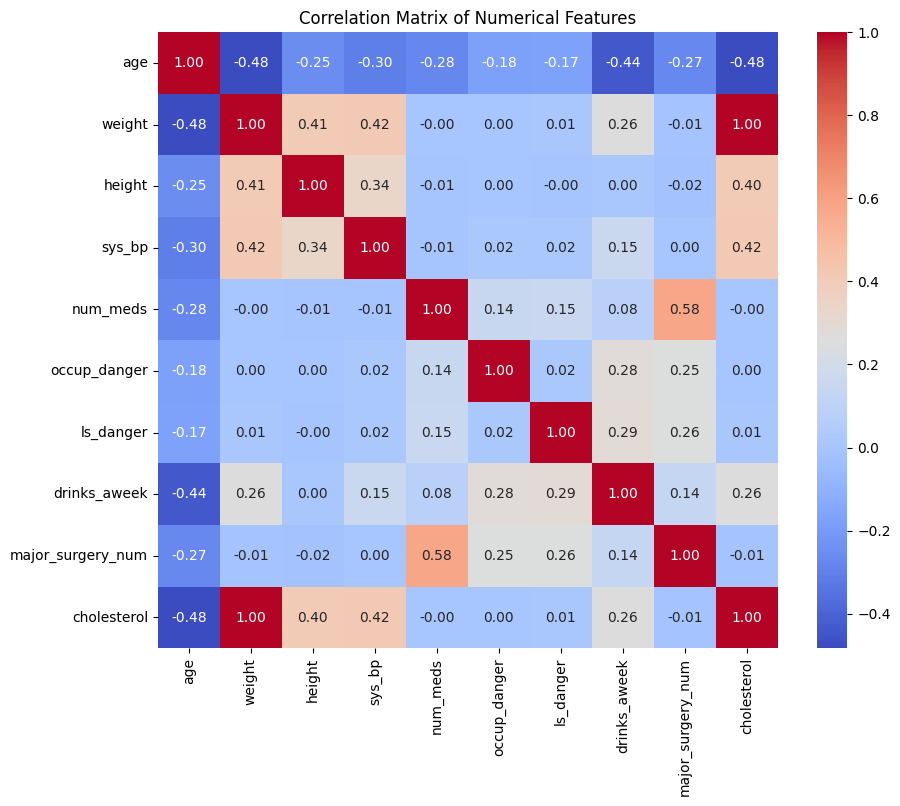

In [21]:
df_numerical = df.select_dtypes(include=['number'])
df_numerical.dtypes
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

**Feature Engineering**
\
We will add a column, BMI, to the dataset (derived from the height and weight columns)

In [22]:
#Adding the BMI column and rounding to 5 decimal places
df['bmi'] = (df['weight'] / (df['height'] **2) )*705

df.head()

,age,weight,sex,height,sys_bp,smoker,nic_other,num_meds,occup_danger,ls_danger,...,major_surgery_num,diabetes,hds,cholesterol,asthma,immune_defic,family_cancer,family_heart_disease,family_cholesterol,bmi
0,100,219,m,74,136,n,n,0,1,1,...,0,n,y,203,n,n,y,n,y,28.194850
1,66,242,m,73,111,n,n,0,1,1,...,0,n,n,228,n,n,n,n,n,32.015388
2,31,197,f,65,112,n,n,7,1,2,...,3,n,y,183,n,n,n,n,n,32.872189
3,42,244,f,69,127,n,n,1,2,3,...,2,n,y,228,n,n,n,n,n,36.131065
4,93,183,f,63,91,y,n,2,3,3,...,2,n,n,169,n,n,n,n,n,32.505669


In [23]:
#Implementing train_test_split
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
print("Data split successful")

X = train_data.drop(columns=['age'])
y = train_data['age']
X_test = temp_data.drop(columns=['age'])
y_test = temp_data['age']

Data split successful


In [24]:
#Standardize certain numerical columns (Leave target variable, age, intact)
num_cols = ['weight', 'bmi', 'sys_bp', 'num_meds', 'drinks_aweek', 'major_surgery_num', 'cholesterol']
bin_cols = ['smoker', 'cannabis', 'opioids', 'addiction', 'diabetes']
fam_cols = ['family_cancer', 'family_heart_disease', 'family_cholesterol']
all_cols = num_cols + bin_cols + fam_cols

scaler = StandardScaler()

# Standardize only the independent variables
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Applying Machine Learning Models

**Implementing a Decision Tree**

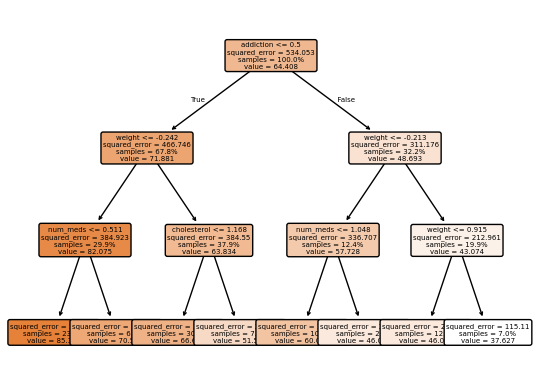

In [25]:
X_dec_tree = X[all_cols].copy()
y_dec_tree = y.copy()


#fix binary columns
for col in bin_cols:
    X_dec_tree[col] = X_dec_tree[col].map({'y': 1, 'n': 0})

for col in fam_cols:
    X_dec_tree[col] = X_dec_tree[col].map({'y': 1, 'n': 0})



clf_entropy = DecisionTreeRegressor(criterion="squared_error", splitter="best", max_depth = 3, min_samples_leaf = 5, random_state=100)
clf_entropy.fit(X_dec_tree, y_dec_tree)
plot_tree(clf_entropy, feature_names=all_cols, fontsize=5, proportion=True, filled=True, rounded=True)
plt.show()


In [34]:
#Implement k-fold cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)
dec_tree_Scores = cross_val_score(clf_entropy, X_dec_tree, y_dec_tree, scoring='neg_mean_squared_error')
dec_tree_Scores = np.abs(dec_tree_Scores)

print("Decision Tree - Cross-validation scores:", dec_tree_Scores)
print("Decision Tree - Mean cross-validation score:", dec_tree_Scores.mean())



Decision Tree - Cross-validation scores: [313.96750805 325.71802798 310.25015773 344.28984409 314.73226362]
Decision Tree - Mean cross-validation score: 321.79156029228915


In [27]:

from sklearn.metrics import mean_squared_error, r2_score
y_pred = clf_entropy.predict(X_dec_tree)
print("RMSE:", np.sqrt(mean_squared_error(y_dec_tree, y_pred)))
print("R²:", r2_score(y_dec_tree, y_pred))

RMSE: 17.706147196588798
R²: 0.4129652499937798


In [28]:
#Check the number of unique y value labels
unique_vals = np.unique(y)
print(f"Number of unique classes: {len(unique_vals)}")
print(f"Class range: {unique_vals.min()} to {unique_vals.max()}")

Number of unique classes: 96
Class range: 25 to 120


**Using XGBoost for Regression**

In [29]:
#Already split into train-test -> We are using the Xtrain
X_xgb = X[all_cols].copy()
y_xgb = y.copy()

#fix binary columns
for col in bin_cols:
    X_xgb[col] = X_xgb[col].map({'y': 1, 'n': 0})

for col in fam_cols:
    X_xgb[col] = X_xgb[col].map({'y': 1, 'n': 0})


#Using XGBoost with K-Fold Cross Validation (5 splits)
xgbmodel = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=100)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgbscores = cross_val_score(xgbmodel, X_xgb, y_xgb, cv=kf, scoring='neg_mean_squared_error')


rmse_scores = np.sqrt(-xgbscores)
print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())


RMSE scores for each fold: [15.67796297 15.01408996 15.35489835 15.00121404 15.32775269]
Average RMSE: 15.27518360295969


**Training a Neural Network - MLP Classifier**

In [30]:
#Use all input variables before condensing down to most important features.

X_mlp = X[all_cols].copy()
y_mlp = y.copy()
#define separate, already-split dataset

#fix binary columns
for col in bin_cols:
    X_mlp[col] = X_mlp[col].map({'y': 1, 'n': 0})

for col in fam_cols:
    X_mlp[col] = X_mlp[col].map({'y': 1, 'n': 0})

#Do the same data processing for the test data for later validation

X_val = X_test[all_cols].copy()
y_val = y_test.copy()

for col in bin_cols:
    X_val[col] = X_val[col].map({'y': 1, 'n': 0})

for col in fam_cols:
    X_val[col] = X_val[col].map({'y': 1, 'n': 0})


mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1600, random_state=42)
mlp.fit(X_mlp, y_mlp)
y_train_pred = mlp.predict(X_mlp)

train_r2 = r2_score(y_mlp, y_train_pred)
print("Training R-squared:", train_r2)

train_mse = mean_squared_error(y_mlp, y_train_pred)
print("Training MSE:", train_mse)

Training R-squared: 0.6407509079359824
Training MSE: 191.85804263638266


In [31]:
#Now we validate with test data

y_val_pred = mlp.predict(X_val)
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation R²:", r2_score(y_val, y_val_pred))

Validation RMSE: 15.697698865269881
Validation R²: 0.5490569129391984
